**LLM Translation with Evaluator Proofreading (Markdown version)**    
Using code created by Ed Donner in his Udemy Agentic AI course  
*Translator: Gemini model*  
*Evaluator: OpenAI model*  

George MacDonald's [***The Princess and the Goblin***](https://github.com/mlschmitt/classic-books-markdown/blob/main/George%20MacDonald/The%20Princess%20and%20the%20Goblin.md) markdown file available from [**Michael Schmitt**](https://github.com/mlschmitt)'s [**classic-books-markdown**](https://github.com/mlschmitt/classic-books-markdown) repo on GitHub. 

For a brief overview and background, visit [**LLM Language Translation Tools**](https://github.com/shandran/llm_translation_tools/tree/main) page on my GitHub repo.

### Set up

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic
import google.generativeai as genai
from IPython.display import Markdown, display
from docx import Document
import re
import tiktoken
import time
import os
from datetime import datetime
from collections import Counter
from openai import NotFoundError

In [2]:
# load API keys
load_dotenv(override=True)

True

In [3]:
# Print the key prefixes to help with any debugging
openai_api_key = os.getenv('OPENAI_API_KEY')
genai.configure(api_key=os.environ["GEMINI_API_KEY"])
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

In [4]:
# LLM model to use
openai_model =  'gpt-4o' # 'o3-2025-04-16' # For better quality but higher cost: 'o3-2025-04-16' # 200K context window 100K max output tokens $2/$8
gemini_model = 'gemini-2.5-flash' # gemini-2.5-pro' # 1M context window 65K max output tokens $1.25/$10 <200K $2.50/$15 >=200K tokens 
claude_model = 'claude-sonnet-4-0' # 200K context window 65K max output tokens $3/$15

openai = OpenAI()
claude = Anthropic()
gemini = genai.GenerativeModel(model_name=gemini_model)

# define languages
source_language = 'English'
translated_language = 'Traditional Chinese'

In [5]:
print(f"Gemini model: {gemini_model}")
print(f"OpenAI model: {openai_model}")
print(f"Claude model: {claude_model}")
print(f"Translation language: {translated_language}")

Gemini model: gemini-2.5-pro
OpenAI model: o3-2025-04-16
Claude model: claude-sonnet-4-0
Translation language: Traditional Chinese


In [6]:
# Open md document with source material
filename = "George_MacDonald_The_Princess_and_the_Goblin_50_lines.md"

In [7]:
# Load the markdown file
with open(filename, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Set up tokenizer (GPT-4-compatible)
enc = tiktoken.encoding_for_model("gpt-4")  # or "gpt-4o" if preferred

# ---------- Structure Detection Helpers ----------
def is_heading(line):
    return re.match(r"^#{1,6} ", line)

def is_list_item(line):
    return re.match(r"^(\s*[-*+] |\s*\d+\.\s)", line)

def is_blockquote(line):
    return line.strip().startswith(">")

def is_code_fence(line):
    # This regex looks for lines that start with at least three backticks
    # and optionally include language specifiers. It also handles closing fences.
    return re.match(r"^\s*`{3,}", line)

def is_blank(line):
    return line.strip() == ""

# ---------- Group Lines into Logical Blocks ----------
blocks = []
current_block = []
in_code_block = False
in_blockquote_block = False # New flag for blockquote

for line in lines:
    if is_code_fence(line):
        # If exiting a blockquote before a code fence, close it out
        if in_blockquote_block and current_block:
            blocks.append("".join(current_block).strip())
            current_block = []
            in_blockquote_block = False

        in_code_block = not in_code_block
        current_block.append(line)
        if not in_code_block: # If just closed a code block
            blocks.append("".join(current_block).strip())
            current_block = []
        continue # Move to next line, as code fence handled itself

    if in_code_block: # If currently inside a code block
        current_block.append(line)
        continue

    # Handle blockquotes
    if is_blockquote(line):
        if not in_blockquote_block: # If starting a new blockquote block
            if current_block: # If there's a preceding block of different type
                blocks.append("".join(current_block).strip())
                current_block = []
            in_blockquote_block = True
        current_block.append(line) # Always append blockquote lines to current_block
    else: # Not a blockquote line
        if in_blockquote_block: # If exiting a blockquote block
            if current_block: # Ensure there's content to append
                blocks.append("".join(current_block).strip())
                current_block = []
            in_blockquote_block = False # Reset the flag

        # Handle other block types outside of blockquote logic
        if is_heading(line) or is_list_item(line):
            if current_block: # If there's a preceding block of different type
                blocks.append("".join(current_block).strip())
                current_block = []
            current_block.append(line)
        elif is_blank(line):
            if current_block: # If there's content to append before a blank line
                blocks.append("".join(current_block).strip())
                current_block = []
            # Do not append blank lines themselves as blocks, they act as separators
        else: # Regular paragraph text
            current_block.append(line)

# Add any remaining content in current_block as a final block
if current_block:
    blocks.append("".join(current_block).strip())

# ---------- Group Blocks into Token-Aware Chunks ----------
target_tokens = 300 # 150
max_tokens = 400 # 180 # Not explicitly used for dynamic splitting in this structure, but good for upper bound
chunks = []
current_chunk = []
current_token_count = 0
chunk_id = 1

for block in blocks:
    block_tokens = len(enc.encode(block))

    # If adding the current block exceeds the target and there's already content in the current chunk
    # then finalize the current chunk and start a new one.
    if current_token_count + block_tokens > target_tokens and current_chunk:
        chunk_text = "\n\n".join(current_chunk) # This is where blocks are joined
        chunks.append({
            "chunk_id": chunk_id,
            "tokens": current_token_count,
            "text": chunk_text
        })
        chunk_id += 1
        current_chunk = []
        current_token_count = 0

    current_chunk.append(block)
    current_token_count += block_tokens

# Add final chunk if there's any remaining content
if current_chunk:
    chunk_text = "\n\n".join(current_chunk)
    chunks.append({
        "chunk_id": chunk_id,
        "tokens": current_token_count,
        "text": chunk_text
    })

# ---------- Optional: Save as JSON ----------
output_json_filename = "markdown_chunks.json"
with open(output_json_filename, "w", encoding="utf-8") as f:
    json.dump(chunks, f, ensure_ascii=False, indent=2)

# ---------- Preview ----------
for chunk in chunks:
    # Print only the first 300 characters for preview to avoid large output
    print(f"\n--- Chunk {chunk['chunk_id']} ({chunk['tokens']} tokens) of {len(chunks)} ---\n{chunk['text'][:300]}{'...' if len(chunk['text']) > 300 else ''}\n")
print(f"\n✅ {len(chunks)} chunks created and saved to '{output_json_filename}'")


--- Chunk 1 (265 tokens) of 12 ---
# Title: The Princess and the Goblin

## Author: George MacDonald

## Year: 1872

-------

###  CHAPTER 1 - Why the Princess Has a Story About Her

There was once a little princess whose father was king over a great country full of mountains and valleys. His palace was built upon one of the mountain...


--- Chunk 2 (126 tokens) of 12 ---
These mountains were full of hollow places underneath; huge caverns, and winding ways, some with water running through them, and some shining with all colours of the rainbow when a light was taken in. There would not have been much known about them, had there not been mines there, great deep pits, w...


--- Chunk 3 (624 tokens) of 12 ---
Now in these subterranean caverns lived a strange race of beings, called by some gnomes, by some kobolds, by some goblins. There was a legend current in the country that at one time they lived above ground, and were very like other people. But for some reason or other, concerning w

### Translation prompt (system_message)

In [8]:
# Prompt instruction
system_message = f"""
You are a professional translator of classic literary works in English.
Your task is to translate chunked markdown inputs (headings, paragraphs, blockquotes, lists, code blocks, etc.) from {source_language} into {translated_language}, preserving all original formatting and markdown syntax exactly.

Requirements:
1. Faithfully render every word and phrase; do NOT summarize, simplify, omit, or add commentary.
2. Use vocabulary and idioms familiar to a general readership audience.
3. Preserve all punctuation, inline code, and block structures.
4. Maintain consistent translation approach across all chunks.
5. Retain capitalization of proper names and headings exactly as in the source.
6. Output only the translated markdown text: no explanations, no extra whitespace beyond what is in the input.

Start each response with the translated chunk; do not include any metadata or system commentary.
"""

messages = [{"role": "user", "content": system_message}]

In [9]:
system_message

'\nYou are a professional translator of classic literary works in English.\nYour task is to translate chunked markdown inputs (headings, paragraphs, blockquotes, lists, code blocks, etc.) from English into Traditional Chinese, preserving all original formatting and markdown syntax exactly.\n\nRequirements:\n1. Faithfully render every word and phrase; do NOT summarize, simplify, omit, or add commentary.\n2. Use vocabulary and idioms familiar to a general readership audience.\n3. Preserve all punctuation, inline code, and block structures.\n4. Maintain consistent translation approach across all chunks.\n5. Retain capitalization of proper names and headings exactly as in the source.\n6. Output only the translated markdown text: no explanations, no extra whitespace beyond what is in the input.\n\nStart each response with the translated chunk; do not include any metadata or system commentary.\n'

In [10]:
gemini

genai.GenerativeModel(
    model_name='models/gemini-2.5-pro',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

In [11]:
print(f"Gemini model: {gemini_model}")
print(f"OpenAI model: {openai_model}")
print(f"Claude model: {claude_model}")
print(f"Translation language: {translated_language}")

Gemini model: gemini-2.5-pro
OpenAI model: o3-2025-04-16
Claude model: claude-sonnet-4-0
Translation language: Traditional Chinese


### Translation function (translate_chunk)

In [12]:
# Translator function with error reporting to 'error', handling empty returns, and a settable max retries 

def translate_chunk(
    text: str,
    system_message: str,
    idx: int = None,
    total: int = None,
    retry_on_rate_limit: bool = True
) -> str:
    """
    Sends one chunk of text through Gemini and returns the translated string.
    Retries once on exceptions or empty responses, and records errors in chunk['error'].
    If both the initial call and retry fail, returns the sentinel "translation failed".
    """
    if idx is not None and total is not None:
        print(
            f"Translating chunk {idx}/{total} "
            f"(first 50 chars): {text[:50]}... | Type: {type(text)}"
        )
   
    prompt = system_message + "\n\n" + text
    attempt = 0
    MAX_RETRIES = 1

    while True:
        try:
            response = gemini.generate_content(
                contents=[{"role": "user", "parts": [prompt]}]
            )
            out = response.text.strip()
            if not out:
                # treat empty response as an error
                raise ValueError("Empty response from Gemini")
            return out

        except Exception as e:
            attempt += 1
            print(f"⚠️  Translation error on chunk {idx}: {e}")
            # record the error into the chunk dict if available
            try:
                chunk.setdefault('error', str(e))
            except NameError:
                pass  # chunk not in scope here

            if not retry_on_rate_limit or attempt > MAX_RETRIES:
                print(f"‼️  Translation failed for chunk {idx}, moving on.")
                return "translation failed"

            print("…retrying after brief pause…")
            time.sleep(2)


### Call translation function

In [13]:
# Start the master timer
master_start = time.perf_counter()

for i, chunk in enumerate(chunks, start=1):
    chunk['error'] = None
    translated = translate_chunk(
        chunk['text'],
        system_message,
        idx=i,
        total=len(chunks),
        retry_on_rate_limit=True
    )
    chunk['check'] = translated
    print(f"✅ Updated chunk_id {chunk['chunk_id']}\n")

# Stop the master timer and report H:M:S
master_end = time.perf_counter()
total_seconds = master_end - master_start
hours   = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = total_seconds % 60

print(
    f"⏱️ Total processing time: "
    f"{hours}h {minutes}m {seconds:.2f}s"
)

Translating chunk 1/12 (first 50 chars): # Title: The Princess and the Goblin

## Author: G... | Type: <class 'str'>
✅ Updated chunk_id 1

Translating chunk 2/12 (first 50 chars): These mountains were full of hollow places underne... | Type: <class 'str'>
✅ Updated chunk_id 2

Translating chunk 3/12 (first 50 chars): Now in these subterranean caverns lived a strange ... | Type: <class 'str'>
✅ Updated chunk_id 3

Translating chunk 4/12 (first 50 chars): ###  CHAPTER 2 - The Princess Loses Herself

I hav... | Type: <class 'str'>
✅ Updated chunk_id 4

Translating chunk 5/12 (first 50 chars): One very wet day, when the mountain was covered wi... | Type: <class 'str'>
✅ Updated chunk_id 5

Translating chunk 6/12 (first 50 chars): Even that is a change, and the princess wakes up a... | Type: <class 'str'>
✅ Updated chunk_id 6

Translating chunk 7/12 (first 50 chars): Up and up she ran--such a long way it seemed to he... | Type: <class 'str'>
✅ Updated chunk_id 7

Translating chunk 8/12 (fir

In [14]:
len(chunks)

12

In [15]:
chunks[0]

{'chunk_id': 1,
 'tokens': 265,
 'text': '# Title: The Princess and the Goblin\n\n## Author: George MacDonald\n\n## Year: 1872\n\n-------\n\n###  CHAPTER 1 - Why the Princess Has a Story About Her\n\nThere was once a little princess whose father was king over a great country full of mountains and valleys. His palace was built upon one of the mountains, and was very grand and beautiful. The princess, whose name was Irene, was born there, but she was sent soon after her birth, because her mother was not very strong, to be brought up by country people in a large house, half castle, half farmhouse, on the side of another mountain, about half-way between its base and its peak.\n\nThe princess was a sweet little creature, and at the time my story begins was about eight years old, I think, but she got older very fast. Her face was fair and pretty, with eyes like two bits of night sky, each with a star dissolved in the blue. Those eyes you would have thought must have known they came from ther

#### Check for errors

In [16]:
# Identify and display error entries
errors = [chunk for chunk in chunks if chunk.get('error')]

# Count
eno_error = len([c for c in chunks if c.get('error') is None])
has_error = len(errors)
print(f"No error: {eno_error}, With error: {has_error}")

# Pretty-print error chunks
print("Chunks containing errors:")
print(json.dumps(errors, ensure_ascii=False, indent=2))

No error: 12, With error: 0
Chunks containing errors:
[]


In [17]:
# chunks

### Evaluation function definition

In [18]:
def evaluate_chunk(
    chunk: dict,
    system_message: str,
    source_language: str,
    translated_language: str,
    translate_func,
    idx: int = None,
    total: int = None,
    retry_on_failure: bool = True
) -> str:
    """
    1) Runs primary evaluation on chunk['check'] and records chunk['primary_feedback'].
    2) If passed, sets chunk['final']=chunk['check'], chunk['final_model']=gemini_model.
    3) If failed and retry_on_failure, translates with Claude, records chunk['alt_feedback'], re-evaluates once.
    4) On fallback pass, sets chunk['final']=fallback text and chunk['final_model']=claude_model; if both fail, final_model=None.
    Returns chunk['final'].
    """

    def _call_evaluator(text_to_check: str):
        # Build the evaluation prompt with localized name exceptions
        evaluation_prompt = f"""
You are a professional translation evaluator reviewing translated classic literary works for a general audience. 
Your task is to assess whether a translated markdown chunk faithfully and accurately follows the original, based on the following criteria:

The input text is chunked and therefore may include partial or incomplete sentences. Do not reject the accuracy of the translation due to chunking issues.

1. **Accuracy**: The meaning is faithfully preserved — no additions, omissions, or summarizations.
2. **Contextual Fidelity**: Terms are rendered precisely and consistently.
3. **Markdown Integrity**: All formatting (headings, lists, blockquotes, punctuation, verse references, etc.) is preserved exactly.
4. **Audience Awareness**: Language attempts to translate idioms and style as best as feasible for a translated work.
5. **Proper Names and Capitalization**: All names and headings match the source formatting, or uses standard, established equivalents in target lan

Source:
{chunk['text']}

Translation:
{text_to_check}

Respond with ONLY raw JSON:
{{
  "passed": true or false,
  "feedback": "If failed, brief specific reason; empty if passed"
}}
""".strip()

        resp = openai.chat.completions.create(
            model=openai_model,
            messages=[{"role": "user", "content": evaluation_prompt}]
        ).choices[0].message.content.strip()
        clean = re.sub(r'^```(?:json)?\r?\n', '', resp)
        clean = re.sub(r'\r?\n```$', '', clean)
        return json.loads(clean)

    # Primary evaluation
    if idx and total:
        print(f"Evaluating chunk {idx}/{total} with {gemini_model}…", end=" ")
    verdict = _call_evaluator(chunk['check'])
    chunk['primary_feedback'] = verdict.get('feedback', "")
    chunk['passed'] = verdict.get('passed', False)

    if chunk['passed']:
        chunk['final'] = chunk['check']
        chunk['final_model'] = gemini_model
        print("→ primary passed")
        return chunk['final']

    # Fallback to Claude
    chunk['alt_feedback'] = None
    if retry_on_failure:
        print("→ primary failed; translating with Claude…")
        claude_resp = claude.messages.create(
                    model=claude_model,
                    messages=[
                        {"role": "user",   "content": system_message + "\n\n" + chunk["text"]
                        }
                    ],
                    max_tokens=1000
                )
        
        alt_text = claude_resp.content[0].text
        chunk['check_alt'] = alt_text

        if idx and total:
            print(f"Re-evaluating chunk {idx}/{total} with {claude_model}…", end=" ")
        verdict2 = _call_evaluator(alt_text)
        chunk['alt_feedback'] = verdict2.get('feedback', "")
        chunk['passed'] = verdict2.get('passed', False)

        if chunk['passed']:
            chunk['final'] = alt_text
            chunk['final_model'] = claude_model
            print("→ fallback passed")
            return chunk['final']

    # Both failed
    reason = chunk['alt_feedback'] or chunk['primary_feedback'] or 'Unknown reason'
    chunk['final'] = (
        f"Translation into {translated_language} failed: {reason}"
    )
    chunk['final_model'] = None
    print(f"→ both evaluations failed: {reason}")
    return chunk['final']


### Call the Evaluation function

In [19]:
# 1) Start the overall timer
master_start = time.perf_counter()

for idx, chunk in enumerate(chunks, start=1):
    # Skip chunks already evaluated
    if 'passed' in chunk and 'final_model' in chunk:
        print(f"--- Chunk {idx}/{len(chunks)} (ID: {chunk['chunk_id']}) already evaluated; skipping.")
        continue

    # Initialize evaluator-stage error field only
    chunk['eval_error'] = None

    print(f"\n--- Chunk {idx}/{len(chunks)} (ID: {chunk['chunk_id']}) ---")
    print("✅ Using existing translation; starting evaluation…")

    try:
        # Call the unified evaluate_chunk (includes fallback)
        final_text = evaluate_chunk(
            chunk,
            system_message,
            source_language,
            translated_language,
            translate_chunk,
            idx=idx,
            total=len(chunks),
            retry_on_failure=True
        )
        chunk['final'] = final_text
    except Exception as e:
        # Catch any unexpected errors in evaluation
        chunk['eval_error'] = str(e)
        chunk['final'] = f"Evaluation error: {e}"
        chunk['final_model'] = None
        print(f"⚠️  Unexpected evaluation error on chunk {chunk['chunk_id']}: {e}")

    # Report outcome
    if chunk['final'].startswith("Translation into") or chunk['final'].startswith("Evaluation error"):
        print(f"‼️  Chunk {chunk['chunk_id']} ultimately failed.\n")
    else:
        print(f"🎉 Chunk {chunk['chunk_id']} passed! Saved to chunk['final'].\n")

# 2) Stop the overall timer
master_end = time.perf_counter()
total_seconds = master_end - master_start
hours = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = total_seconds % 60

print(
    f"⏱️ Total evaluation time: {hours}h {minutes}m {seconds:.2f}s"
)


--- Chunk 1/12 (ID: 1) ---
✅ Using existing translation; starting evaluation…
Evaluating chunk 1/12 with gemini-2.5-pro… → primary passed
🎉 Chunk 1 passed! Saved to chunk['final'].


--- Chunk 2/12 (ID: 2) ---
✅ Using existing translation; starting evaluation…
Evaluating chunk 2/12 with gemini-2.5-pro… → primary passed
🎉 Chunk 2 passed! Saved to chunk['final'].


--- Chunk 3/12 (ID: 3) ---
✅ Using existing translation; starting evaluation…
Evaluating chunk 3/12 with gemini-2.5-pro… → primary passed
🎉 Chunk 3 passed! Saved to chunk['final'].


--- Chunk 4/12 (ID: 4) ---
✅ Using existing translation; starting evaluation…
Evaluating chunk 4/12 with gemini-2.5-pro… → primary passed
🎉 Chunk 4 passed! Saved to chunk['final'].


--- Chunk 5/12 (ID: 5) ---
✅ Using existing translation; starting evaluation…
Evaluating chunk 5/12 with gemini-2.5-pro… → primary passed
🎉 Chunk 5 passed! Saved to chunk['final'].


--- Chunk 6/12 (ID: 6) ---
✅ Using existing translation; starting evaluation…
Evalua

In [20]:
chunks[0]

{'chunk_id': 1,
 'tokens': 265,
 'text': '# Title: The Princess and the Goblin\n\n## Author: George MacDonald\n\n## Year: 1872\n\n-------\n\n###  CHAPTER 1 - Why the Princess Has a Story About Her\n\nThere was once a little princess whose father was king over a great country full of mountains and valleys. His palace was built upon one of the mountains, and was very grand and beautiful. The princess, whose name was Irene, was born there, but she was sent soon after her birth, because her mother was not very strong, to be brought up by country people in a large house, half castle, half farmhouse, on the side of another mountain, about half-way between its base and its peak.\n\nThe princess was a sweet little creature, and at the time my story begins was about eight years old, I think, but she got older very fast. Her face was fair and pretty, with eyes like two bits of night sky, each with a star dissolved in the blue. Those eyes you would have thought must have known they came from ther

#### Pass-fail counts

In [21]:
# Only include entries where 'passed' exists
counts = Counter(c.get('passed') for c in chunks if 'passed' in c)
print(f"Passed: {counts[True]}, Failed: {counts[False]}")

Passed: 12, Failed: 0


#### Print failed entries

In [22]:
# 1) Get only the entries where passed is False
fails = [chunk for chunk in chunks if chunk.get('passed') is False]

# 2) Dump them as nicely formatted JSON
print(json.dumps(fails, ensure_ascii=False, indent=2))

[]


### Token size distribution

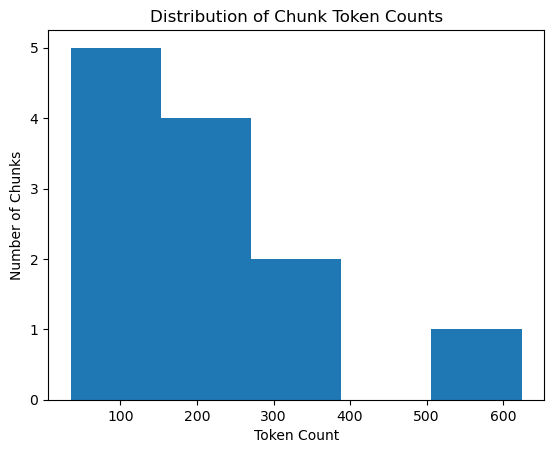

In [23]:
import matplotlib.pyplot as plt

# Extract token counts
tokens = [chunk['tokens'] for chunk in chunks]

# Create histogram
plt.figure()
plt.hist(tokens, bins='auto')
plt.title('Distribution of Chunk Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Number of Chunks')
plt.show()


# Clean up failed entries, if any

In [24]:

# Mini evaluator function (reuse existing prompt logic)
def mini_evaluate(text_to_check: str, source_text: str) -> dict:
    evaluation_prompt = f"""
You are a professional translation evaluator reviewing translated Biblical education materials for a Protestant/Evangelical audience.
Your task is to assess whether a translated markdown chunk faithfully and accurately follows the original, based on these criteria:

1. **Accuracy**: Meaning is preserved—no additions, omissions, or summarizations.
2. **Theological Fidelity**: Key theological terms are rendered precisely.
3. **Markdown Integrity**: All headings, lists, blockquotes, punctuation, verse references must be preserved.
4. **Audience Awareness**: Language reflects Protestant/Evangelical style and idioms.
5. **Proper Names**: Preserve proper names exactly, except standard localized equivalents (e.g., Spanish Bible book titles).

Source:
{source_text}

Translation:
{text_to_check}

Respond with ONLY raw JSON:
{{
  "passed": true or false,
  "feedback": "If failed, brief specific reason; empty if passed"
}}
""".strip()

    resp = openai.chat.completions.create(
        model=openai_model,
        messages=[{"role": "user", "content": evaluation_prompt}]
    ).choices[0].message.content.strip()

    clean = re.sub(r'^```(?:json)?\r?\n', '', resp)
    clean = re.sub(r'\r?\n```$', '', clean)
    return json.loads(clean)

# Identify currently failing chunks
fails = [chunk for chunk in chunks if not chunk.get('passed')]
print(f"🔄 Re-evaluating {len(fails)} initially failed chunks…")
start = time.perf_counter()

for idx, chunk in enumerate(fails, start=1):
    print(f"→ [{idx}/{len(fails)}] Re-checking chunk_id {chunk['chunk_id']}…")
    verdict = mini_evaluate(chunk['check'], chunk['text'])
    if verdict.get('passed'):
        chunk['final'] = chunk['check']
        chunk['final_model'] = gemini_model
        print(f"   ✅ chunk_id {chunk['chunk_id']} now passes primary re-check.")
    else:
        print(f"   ❌ chunk_id {chunk['chunk_id']} failed primary re-check: {verdict.get('feedback')}\n   → Attempting Claude fallback…")
        # run Claude fallback
        claude_resp = claude.messages.create(
            model=claude_model,
            messages=[
                {"role": "user",   "content": system_message + "\n\n" + chunk["text"]
                }
            ],
            max_tokens=1000
        )
        alt_text = claude_resp.completion.strip()
        chunk['check_alt'] = alt_text
        # re-evaluate fallback
        fallback_verdict = mini_evaluate(alt_text, chunk['text'])
        if fallback_verdict.get('passed'):
            chunk['final'] = alt_text
            chunk['final_model'] = claude_model
            print(f"   ✅ chunk_id {chunk['chunk_id']} now passes with Claude fallback.")
        else:
            print(f"   ❌ chunk_id {chunk['chunk_id']} still fails fallback: {fallback_verdict.get('feedback')}")

end = time.perf_counter()
elapsed = end - start
hours = int(elapsed // 3600)
minutes = int((elapsed % 3600) // 60)
seconds = elapsed % 60
print(f"\n⏱️ Total re-evaluation (with fallback) time: {hours}h {minutes}m {seconds:.2f}s")


🔄 Re-evaluating 0 initially failed chunks…

⏱️ Total re-evaluation (with fallback) time: 0h 0m 0.00s


In [25]:
fails

[]

In [26]:
from collections import Counter

# extract all final_model values (will include None if missing)
models = [chunk.get('final_model') for chunk in chunks]

# tabulate counts
counts = Counter(models)

print(counts)
# e.g. Counter({'model_A': 123, 'model_B': 77, None: 5})


Counter({'gemini-2.5-pro': 12})


### Save json

In [27]:
# drop the .md extension
base = os.path.splitext(filename)[0]

# remove spaces if any from output language
output_language = translated_language.replace(" ", "")

# timestamp in yyyy-mm-dd-hhMMSS format
ts = datetime.now().strftime("%Y-%m-%d-%H%M%S")

# build the output filename
out_fname = f"{base}_{output_language}_{gemini_model}_{openai_model}_{ts}.json"

# write to disk
with open(out_fname, "w", encoding="utf-8") as f:
    json.dump(chunks, f, ensure_ascii=False, indent=2)

print(f"✅ Exported results to {out_fname}")


✅ Exported results to George_MacDonald_The_Princess_and_the_Goblin_50_lines_TraditionalChinese_gemini-2.5-pro_o3-2025-04-16_2025-06-27-193324.json


### Create and save an interlinear markdown file

In [28]:
# 1) Turn your existing JSON filename into a .md filename
base = os.path.splitext(out_fname)[0]
markdown_fname = base + '_interlinear' + '.md'

# 2) Write each chunk’s original + final translation into the .md
with open(markdown_fname, "w", encoding="utf-8") as md_file:
    for chunk in chunks:
        md_file.write(chunk['text'])
        md_file.write("\n\n")
        md_file.write(chunk.get('final', ''))
        md_file.write("\n\n")

print(f"✅ Exported merged markdown to {markdown_fname}")


✅ Exported merged markdown to George_MacDonald_The_Princess_and_the_Goblin_50_lines_TraditionalChinese_gemini-2.5-pro_o3-2025-04-16_2025-06-27-193324_interlinear.md


### Create and save translation only markdown file

In [29]:
# 1) Turn your existing JSON filename into a .md filename
base = os.path.splitext(out_fname)[0]
markdown_fname = base + '_translation_only' + '.md'

# 2) Write each chunk’s original + final translation into the .md
with open(markdown_fname, "w", encoding="utf-8") as md_file:
    for chunk in chunks:
        md_file.write(chunk.get('final', ''))
        md_file.write("\n\n")

print(f"✅ Exported merged markdown to {markdown_fname}")

✅ Exported merged markdown to George_MacDonald_The_Princess_and_the_Goblin_50_lines_TraditionalChinese_gemini-2.5-pro_o3-2025-04-16_2025-06-27-193324_translation_only.md
